# Training Spiking Neural Networks

## Introduction

In recent years, there has been a surge of interest in training Spiking Neural Networks (SNNs) for meaningful computation. On one hand, this surge is driven by the limited achievements of more traditional, often considered more biologically plausible, learning paradigms in creating functional neural networks that solve interesting computational problems. Deep Neural Networks have undeniably succeeded in solving a variety of challenging computational problems, bridging this limitation. This success has both raised the bar and posed the question of how this progress translates to Spiking Neural Networks.

The rise of deep learning over the past decade is largely attributed to the advancements in GPUs and their computational power, the expansion of training datasets, and perhaps most importantly, the improved understanding of the characteristics and requirements of the backpropagation of error algorithm. For instance, we now know that we must avoid the vanishing and exploding gradient problems, an achievement that can be realized by choosing reasonable nonlinear functions, appropriate weight initialization, and suitable optimizers. Powerful software packages supporting automatic differentiation have made handling deep neural networks easier than ever before. This development raises the question: how much can we learn from deep learning and its tools and apply it to training Spiking Neural Networks? Although these questions cannot be fully answered at present, it seems that we can learn a lot.

In this tutorial, we use [`brainstate`](https://brainstate.readthedocs.io/en/latest/) along with tools from the [Brain Dynamics Programming Ecosystem](https://ecosystem-for-brain-dynamics.readthedocs.io/en/latest/) to build a Spiking Neural Network step by step. To be clear, our goal is to build networks that solve (simple) real-world problems. To this end, we focus on classification problems and use supervised learning in conjunction with the backpropagation algorithm mentioned above. To do so, we must overcome the vanishing gradient problem caused by the binary nature of spikes themselves.

In this tutorial, we will first show how a simple feedforward Leaky Integrate-and-Fire (LIF) neuron-based and conductance-based synaptic Spiking Neural Network (SNN) can be formally mapped to a discrete-time Recurrent Neural Network (RNN). We will leverage this formulation to explain why gradients vanish at the time of spikes and demonstrate a method to mitigate this issue. Specifically, we will introduce surrogate gradients and provide practical examples of how to implement them in Brainstate.

## Mapping LIF Neurons to RNN Dynamics

The de facto standard neuron model in network simulations in computational neuroscience is the Leaky Integrate-and-Fire (LIF) neuron model, which is typically written formally as a time-continuous dynamical system in differential form:

$$\tau_\mathrm{mem} \frac{\mathrm{d}U_i^{(l)}}{\mathrm{d}t} = -(U_i^{(l)}-U_\mathrm{rest}) + RI_i^{(l)}$$

where $U_i$ is the membrane potential of neuron $i$ in layer $l$, $U_\mathrm{rest}$ is the resting potential, $\tau_\mathrm{mem}$ is the membrane time constant, $R$ is the input resistance, and $I_i$ is the input current. The membrane potential $U_i$ characterizes the hidden state of each neuron and, importantly, it is not directly passed to downstream neurons. However, when the membrane voltage of a neuron exceeds a threshold $\vartheta$, the neuron fires an action potential or spike at time $t$. After firing a spike, the neuron's membrane voltage is reset $U_i \rightarrow U_\mathrm{rest}$. We write

$$S_i^{(l)}(t)=\sum_{k \in C_i^l} \delta(t-t_j^k)$$ 

to denote the spike train (i.e., the sum of all spikes $C_i^l$ fired by neuron $i$ in layer $l$). Here, $\delta$ is the Dirac delta function, and $t_i^k$ are the relevant firing times of the neuron.

Spikes propagate along axons and generate postsynaptic currents in connected neurons. Using the above formalism, we can write

$$\frac{\mathrm{d}I_i}{\mathrm{d}t}= -\frac{I_i(t)}{\tau_\mathrm{syn}} + \sum_j W_{ij} S_j^{(0)}(t) + \sum_j V_{ij} S_j^{(1)}(t)$$

where we have introduced the synaptic weight matrices $W_{ij}$ (feedforward), $V_{ij}$ (recurrent), and the synaptic decay time constant $\tau_\mathrm{syn}$.

To make an explicit connection with RNNs, we now express the above equations in discrete-time form. For brevity, we switch to natural units $U_\mathrm{rest}=0$, $R=1$, and $\vartheta=1$. Our argument is not affected by this choice, and all results can be rescaled to physical units. To highlight the nonlinearity of spikes, we first note that we can set

$$S_i^{(l)}(t)=\Theta(U_i^{(l)}(t)-\vartheta)$$

where $\Theta$ denotes the Heaviside step function.

Assuming a small simulation time step $\Delta_t>0$, we can approximate the synaptic dynamics as follows:

$$I_i^{(l)}(t+1) = \alpha I_i^{(l)}(t) + \sum_j W_{ij} S_j^{(l-1)}(t) +\sum_j V_{ij} S_j^{(l)}(t)$$

where the constant $\alpha=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{syn}} \right)$. Additionally, the membrane dynamics can be written as

$$U_i^{(l)}(t+1) = \underbrace{\beta U_i^{(l)}(t)}_{\mathrm{leak}} + \underbrace{I_i^{(l)}(t)}_{\mathrm{input}} -\underbrace{S_i^{(l)}(t)}_{\mathrm{reset}}$$

where the output $S_i(t) = \Theta(U_i(t)-1)$ and the constant $\beta=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{mem}}\right)$. Note the different terms on the right-hand side of the equation, which are responsible for: i) leakage, ii) synaptic input, and iii) spike reset.

These equations can be succinctly summarized as a computational graph of an RNN with specific connectivity structures.

<p align="center">
    <img src="https://raw.githubusercontent.com/surrogate-gradient-learning/spytorch/refs/heads/master/notebooks/figures/snn_graph/snn_graph.png" alt="snn_graph"/>
</p>

Time flows from left to right. Inputs enter the network at each time step from the bottom of the graph ($S_i^{(0)}$). These inputs successively affect the synaptic currents $I_i^{(1)}$, the membrane potentials $U_i^{(1)}$, and finally the spike outputs $S_i^{(1)}$. Additionally, dynamic quantities are fed directly into future time steps. For clarity, the index $i$ is omitted in the figure.

The computational graph showcases a concept called time unfolding, which emphasizes the duality between deep neural networks and recurrent neural networks, the latter being nothing but deep networks in time (with bound weights). Due to this fact, we can use backpropagation through time (BPTT) to train RNNs. Let us first implement the above dynamics in a three-layer spiking neural network in Brainstate.

## Example of Building and Training a Spiking Neural Network

We start by importing the required libraries.

In [1]:
import time

import braintools as bts
import brainunit as u
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import brainstate 

In [2]:
num_inputs  = 100   # Number of input neurons
num_hidden  = 4     # Number of hidden neurons
num_outputs = 2     # Number of output neurons

As we have seen above, we are technically simulating an RNN. Thus, we have to simulate our neurons for a certain number of timesteps. We will use 1ms timesteps, and we want to simulate our network for 200 timesteps.

In [3]:
time_step = 1 * u.ms
brainstate.environ.set(dt=time_step)   # Set the time step for the simulation
num_steps  = 200

To take advantage of parallelism, we will set up our code to work on batches of data like this is usually done for neural networks that are trained in a supervised manner.
To that end, we specify a batch size here.

In [4]:
batch_size = 256

With these basic design choices made, we can now start building the actual network.

### Defining the Spiking Neural Network (SNN)

- **The class inherits from `bst.nn.DynamicsGroup`**:
  - `bst.nn.DynamicsGroup` is a class that contains dynamic neural network components, used to simulate the dynamical behavior of neurons over time.
  - By inheriting from `DynamicsGroup`, the `SNN` class can leverage the tools provided by the framework to manage state updates and activity simulations of the spiking neural network.

- **`__init__` constructor method**:
  - The `__init__` method initializes the network structure, including connections from the input to the recurrent layer, the spiking neuron model of the recurrent layer, connections from the recurrent layer to the output layer, and the processing units of the output layer.

#### Connections from Input Layer to Recurrent Layer (`self.i2r`)

- **`bst.nn.Sequential`**: Used to sequentially combine multiple layers. This contains two layers: a linear layer and an exponential decay layer.
  
- **Linear Layer (`bst.nn.Linear`)**:
  - **Function**: Transfers signals from the input layer to the recurrent layer.
  - **Parameters**:
    - `num_in`: Number of neurons in the input layer.
    - `num_rec`: Number of neurons in the recurrent layer.
    - `w_init`: Weight initialization method, using Kaiming Normal initialization, suitable for activation functions like ReLU.
    - `b_init`: Bias initialization, set to zero initialization here.

- **Exponential Decay Layer (`bst.nn.Expon`)**:
  - **Function**: Simulates the exponential decay characteristics of input signals over time, making the input signals more consistent with the dynamical characteristics of biological neurons.
  - **Parameters**:
    - `num_rec`: Specifies the number of neurons in the recurrent layer.
    - `tau`: Time constant, controlling the rate of exponential decay, set to `10 ms` here.
    - `g_initializer`: Initializes the value of parameter `g`, set to 0 here, representing zero initial input current.

#### Recurrent Layer (`self.r`)

- **LIF Neuron Model (`bst.nn.LIF`)**:
  - **Function**: The recurrent layer uses the Leaky Integrate-and-Fire (LIF) neuron model, a widely applied biological neuron model for spiking activity.
  - **Parameters**:
    - `num_rec`: Number of neurons in the recurrent layer.
    - `tau`: Time constant, controlling the rate of potential leakage, set to `20 ms` here.
    - `V_reset`: Reset value of the membrane potential after spiking, set to `0 mV` here.
    - `V_rest`: Resting membrane potential value of the neuron, also `0 mV`.
    - `V_th`: Threshold of the membrane potential, set to `1 mV`, exceeding which the neuron will fire a spike.
    - `spk_fun`: Defines the activation function for spiking, using `bst.surrogate.ReluGrad()` as the approximate derivative method for the spike function.

#### Connections from Recurrent Layer to Output Layer (`self.r2o`)

- **Linear Layer**:
  - **Function**: Transfers output signals from the recurrent layer to the output layer.
  - **Parameters**:
    - `num_rec`: Number of neurons in the recurrent layer.
    - `num_out`: Number of neurons in the output layer.
    - `w_init`: Weight initialization method, also using Kaiming Normal initialization.

#### Output Layer (`self.o`)

- **Exponential Decay Layer**:
  - **Function**: Simulates the decay behavior of output layer signals over time.
  - **Parameters**:
    - `num_out`: Number of neurons in the output layer.
    - `tau`: Time constant for decay, set to `10 ms` here.
    - `g_initializer`: Initial value for output current set to zero.

In [ ]:
class SNN(brainstate.nn.DynamicsGroup):
    def __init__(self, num_in, num_rec, num_out):
        # Initialize the parent class DynamicsGroup
        super(SNN, self).__init__()

        # Parameter definitions
        self.num_in = num_in   # Number of neurons in the input layer
        self.num_rec = num_rec # Number of neurons in the recurrent layer
        self.num_out = num_out # Number of neurons in the output layer

        # Define connections from the input layer to the recurrent layer (synapse: i->r)
        # Use Sequential to connect the linear layer and the exponential decay layer together
        self.i2r = brainstate.nn.Sequential(
            # Linear layer: used to map input signals to the recurrent layer
            brainstate.nn.Linear(
                num_in, num_rec,  # Connections from the input layer to the recurrent layer
                w_init=brainstate.nn.KaimingNormal(scale=7 * (1 - (u.math.exp(-brainstate.environ.get_dt() / (1 * u.ms)))), unit=u.mA),  # Use Kaiming Normal initialization for weights
                b_init=brainstate.nn.ZeroInit(unit=u.mA)  # Bias initialized to zero
            ),
            # Exponential decay layer: decays the signal over time to match biological neuron dynamics
            brainstate.nn.Expon(num_rec, tau=10. * u.ms, g_initializer=brainstate.nn.Constant(0. * u.mA))
        )

        # Define the recurrent layer (r), using the LIF neuron model
        self.r = brainstate.nn.LIF(
            num_rec,              # Number of neurons in the recurrent layer
            tau=20 * u.ms,        # Time constant, controlling the rate of membrane potential decay
            V_reset=0 * u.mV,     # Reset value of the membrane potential
            V_rest=0 * u.mV,      # Resting membrane potential
            V_th=1. * u.mV,       # Threshold of the membrane potential, exceeding which the neuron fires a spike
            spk_fun=braintools.surrogate.ReluGrad()  # Approximate derivative function for spike implementation
        )

        # Define connections from the recurrent layer to the output layer (synapse: r->o), using a linear layer
        self.r2o = brainstate.nn.Linear(
            num_rec, num_out,          # Connections from the recurrent layer to the output layer
            w_init=brainstate.nn.KaimingNormal()  # Use Kaiming Normal initialization for weights
        )

        # Define the output layer (o), using an exponential decay layer to simulate the time decay of output signals
        self.o = brainstate.nn.Expon(
            num_out,                    # Number of neurons in the output layer
            tau=10. * u.ms,             # Time constant, controlling the rate of output signal decay
            g_initializer=brainstate.nn.Constant(0.)  # Initialize current to zero
        )

    # update method: used to perform one update of the network, returning the output of the output layer
    def update(self, spike):
        # Sequentially compute through i2r, r, r2o, and o
        return self.o(self.r2o(self.r(self.i2r(spike))))

    # predict method: used to predict and obtain the membrane potential values of the recurrent layer, spike outputs, and final output
    def predict(self, spike):
        # Compute the spike outputs of the recurrent layer
        rec_spikes = self.r(self.i2r(spike))
        # Compute the final output
        out = self.o(self.r2o(rec_spikes))
        # Return the membrane potential values of the recurrent layer, recurrent layer spike outputs, and final output
        return self.r.V.value, rec_spikes, out

In [ ]:
net = SNN(num_inputs, num_hidden, num_outputs)

### Simple Synthetic Dataset

We start by generating some random spiking dataset, which we will use as input to our network. Initially, we will work with a single batch of data.

Suppose we want our network to classify a set of different sparse input spike trains into two categories.

To generate some synthetic data, we fill a tensor of shape (batch_size x num_steps x num_inputs) with random uniform numbers between 0 and 1 and use this to generate our input dataset:

In [7]:
freq = 5 * u.Hz
x_data = brainstate.random.rand(num_steps, batch_size, net.num_in) < freq * brainstate.environ.get_dt()
y_data = u.math.asarray(brainstate.random.rand(batch_size) < 0.5, dtype=int)

Note that there is no structure in the data (because it is entirely random). Thus, we won't worry about generalization now and only care about our ability to overfit these data with the spiking neural network we are going to build in a jiffy.

If we plot the spike raster of the first input pattern, this synthetic dataset looks as follows.

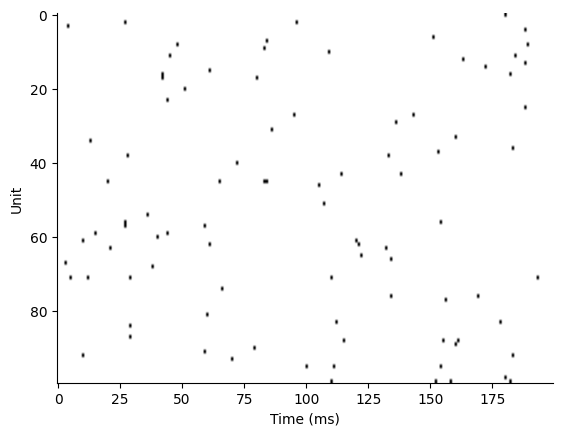

In [8]:
data_id = 0
plt.imshow(x_data.swapaxes(0, 1)[data_id].transpose(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

### Visualizing Neuron Membrane Potentials

Define a helper function `plot_voltage_traces` to plot the membrane potentials and spike activities of neurons.

In [9]:
def plot_voltage_traces(mem, spk=None, dim=(3, 5), spike_height=5, show=True):
    fig, gs = bts.visualize.get_figure(*dim, 3, 3)
    if spk is not None:
        mem[spk > 0.0] = spike_height
    if isinstance(mem, u.Quantity):
        mem = mem.to_decimal(u.mV)
    for i in range(np.prod(dim)):
        if i == 0:
            a0 = ax = plt.subplot(gs[i])
        else:
            ax = plt.subplot(gs[i], sharey=a0)
        ax.plot(mem[:, i])
    if show:
        plt.show()

### Testing the Untrained Network Performance

Test the network before training and visualize the changes in membrane potentials using `plot_voltage_traces`.

In [10]:
def print_classification_accuracy(output, target):
    """ Dirty little helper function to compute classification accuracy. """
    m = u.math.max(output, axis=0)  # max over time
    am = u.math.argmax(m, axis=1)  # argmax over output units
    acc = u.math.mean(target == am)  # compare to labels
    print("Accuracy %.3f" % acc)

def predict_and_visualize_net_activity(net):
    brainstate.nn.init_all_states(net, batch_size=batch_size)
    vs, spikes, outs = brainstate.transform.for_loop(net.predict, x_data, pbar=brainstate.transform.ProgressBar(10))
    plot_voltage_traces(vs, spikes, spike_height=5 * u.mV, show=False)
    plot_voltage_traces(outs)
    print_classification_accuracy(outs, y_data)

  0%|          | 0/200 [00:00<?, ?it/s]

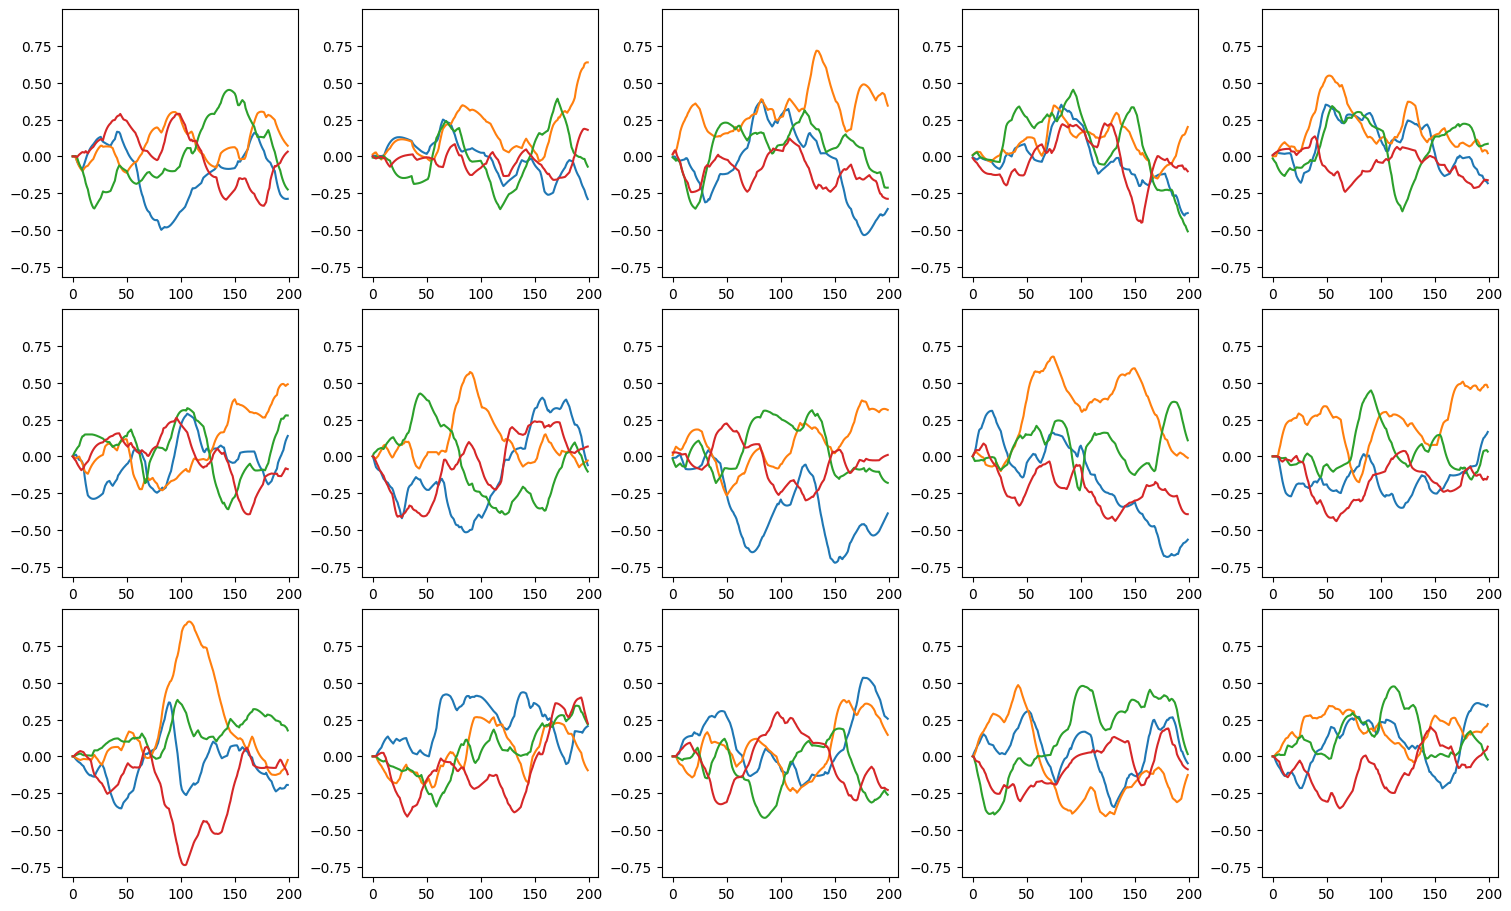

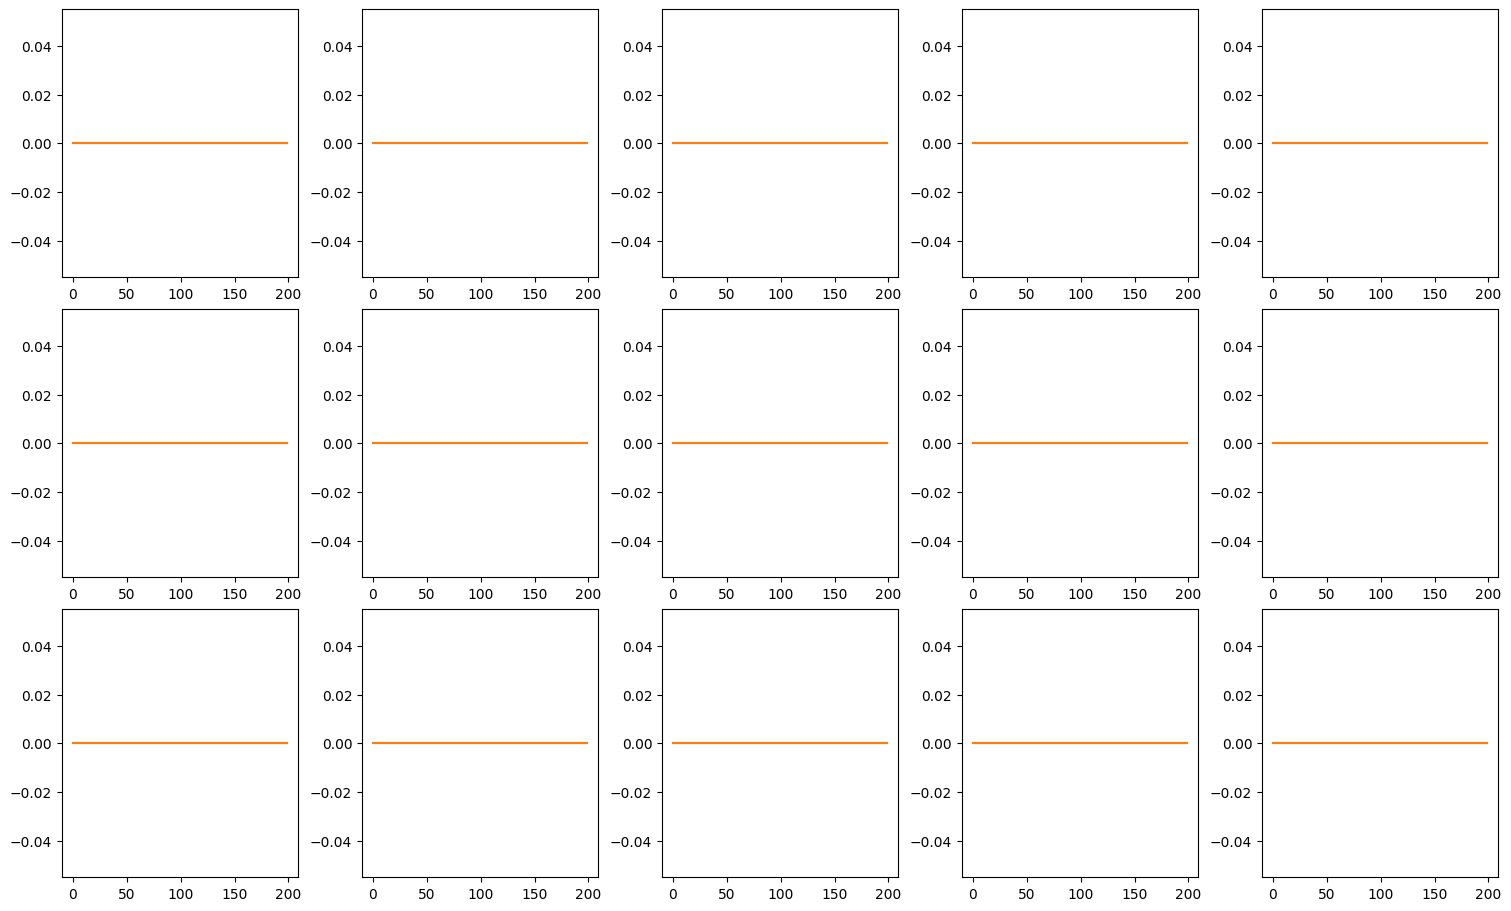

Accuracy 0.496


In [11]:
predict_and_visualize_net_activity(net)

As you can see, our random initialization gives us some sporadic spikes. And calculate the classification accuracy of this random network. We will see that this accuracy is around 50%, as it should be since that corresponds to the chance level of our synthetic task.

### Defining the Optimizer and Loss Function

Use the Adam optimizer and define the loss function as cross-entropy loss.

In [12]:
optimizer = brainstate.optim.Adam(lr=3e-3, beta1=0.9, beta2=0.999)
optimizer.register_trainable_weights(net.states(brainstate.ParamState))

def loss_fn():
    predictions = brainstate.transform.for_loop(net.update, x_data)
    predictions = u.math.mean(predictions, axis=0)
    return bts.metric.softmax_cross_entropy_with_integer_labels(predictions, y_data).mean()

### Training the Network

Define the training function and train the network.

In [13]:
@brainstate.transform.jit
def train_fn():
    brainstate.nn.init_all_states(net, batch_size=batch_size)
    grads, l = brainstate.augment.grad(loss_fn, net.states(brainstate.ParamState), return_value=True)()
    optimizer.update(grads)
    return l

train_losses = []
for i in range(1, 3001):
    loss = train_fn()
    train_losses.append(loss)
    if i % 100 == 0:
        print(f'Epoch {i}, Loss = {loss:.4f}')

Epoch 100, Loss = 0.5864
Epoch 200, Loss = 0.5374
Epoch 300, Loss = 0.5120
Epoch 400, Loss = 0.4886
Epoch 500, Loss = 0.4733
Epoch 600, Loss = 0.4521
Epoch 700, Loss = 0.4292
Epoch 800, Loss = 0.4113
Epoch 900, Loss = 0.3859
Epoch 1000, Loss = 0.3626
Epoch 1100, Loss = 0.3427
Epoch 1200, Loss = 0.3142
Epoch 1300, Loss = 0.2934
Epoch 1400, Loss = 0.2753
Epoch 1500, Loss = 0.2541
Epoch 1600, Loss = 0.2364
Epoch 1700, Loss = 0.2169
Epoch 1800, Loss = 0.2026
Epoch 1900, Loss = 0.1876
Epoch 2000, Loss = 0.1705
Epoch 2100, Loss = 0.1524
Epoch 2200, Loss = 0.1412
Epoch 2300, Loss = 0.1283
Epoch 2400, Loss = 0.1178
Epoch 2500, Loss = 0.1072
Epoch 2600, Loss = 0.0983
Epoch 2700, Loss = 0.0881
Epoch 2800, Loss = 0.0861
Epoch 2900, Loss = 0.0772
Epoch 3000, Loss = 0.0709


### Visualizing Training Loss

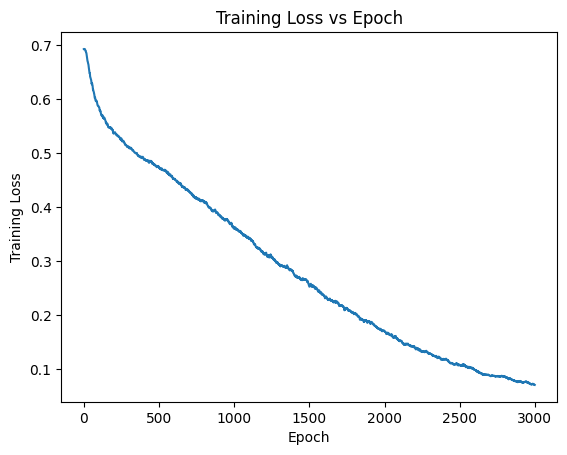

In [14]:
plt.plot(np.asarray(jnp.asarray(train_losses)))
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epoch")
plt.show()

### Testing Network Performance

  0%|          | 0/200 [00:00<?, ?it/s]

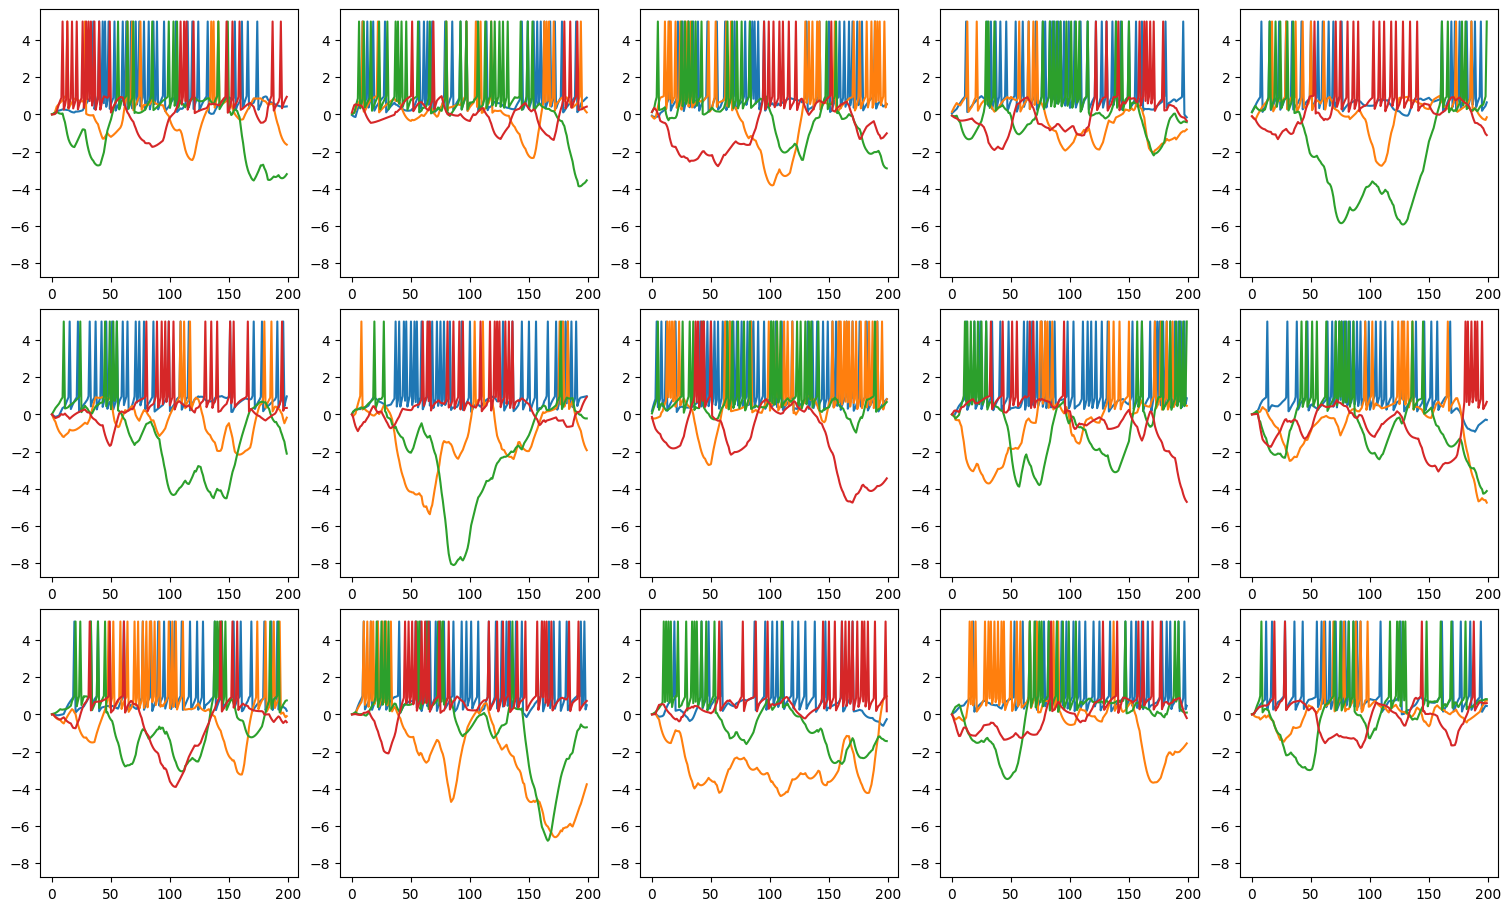

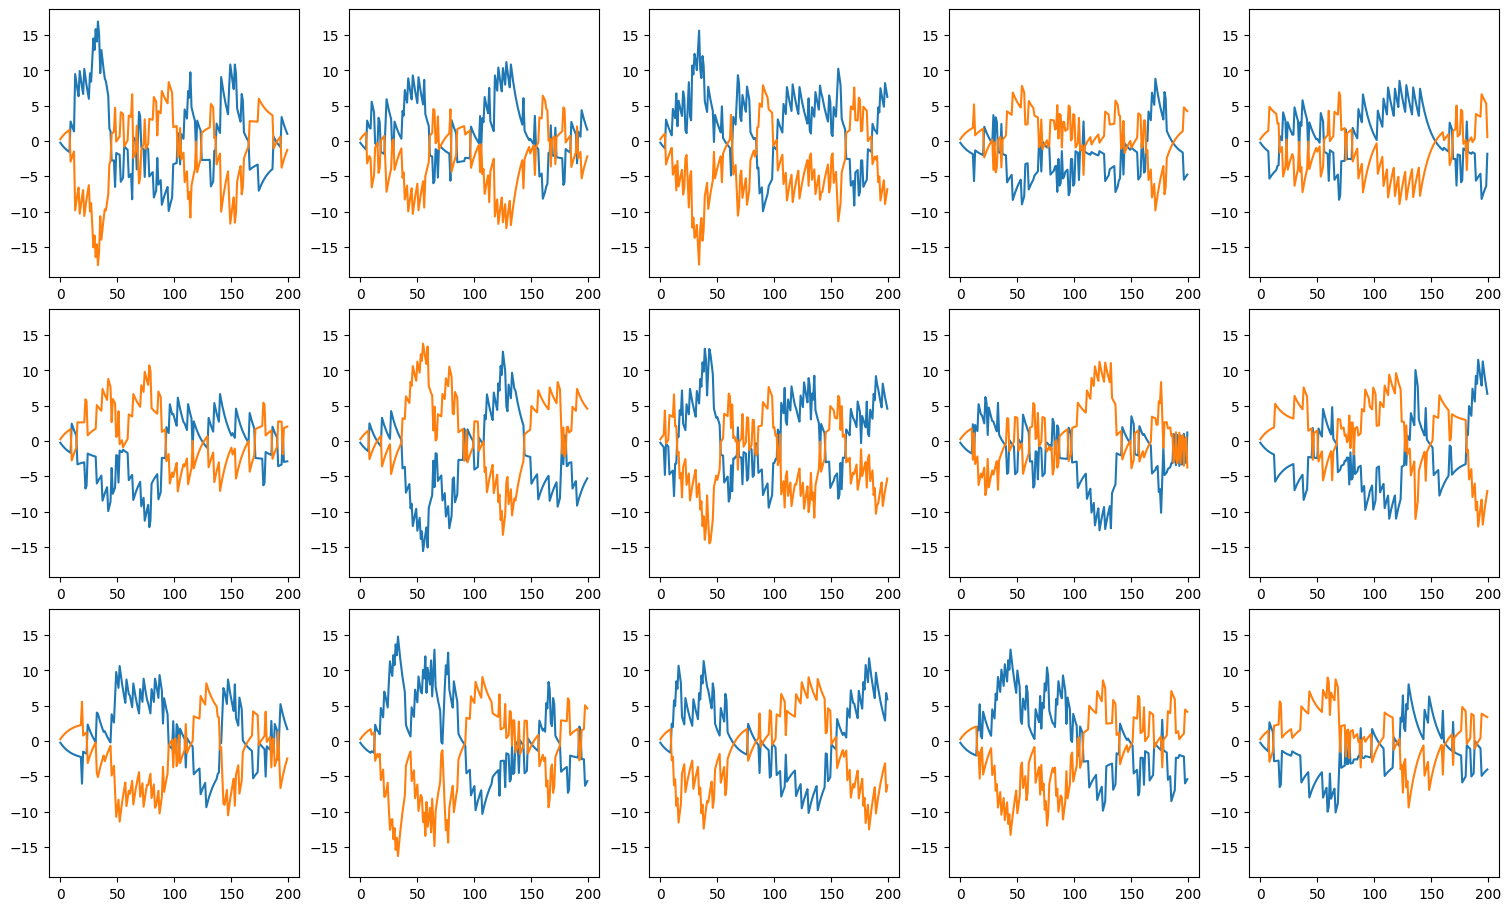

Accuracy 0.852


In [15]:
predict_and_visualize_net_activity(net)